# Renewable Energy Prediction
Data from: https://data.open-power-system-data.org/

# Data Import and Clearning

In [1238]:
#Importing libraries for visualization, graphs, and modeling
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from pylab import *
from scipy import special, optimize
import sys
import os
pd.set_option('display.max_columns', None)


In [1239]:
robbie_filepath_prod = "/Users/robertprior/Desktop/ML Projects/Final Project/time_series_60min_singleindex.csv"
robbie_filepath_w = "/Users/robertprior/Desktop/ML Projects/Final Project/weather_data.csv"

lindsey_filepath_prod = "/Users/LindseyTakeuchi/Downloads/time_series_60min_singleindex (1).csv"
lindsey_filepath_w = "/Users/LindseyTakeuchi/Downloads/weather_data.csv"

#collin_filepath_prod =
#collin_filepath_w =

In [1240]:
#Robbie
prod = pd.read_csv(robbie_filepath_prod, usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
weather = pd.read_csv(robbie_filepath_w, parse_dates=[0], index_col=0)


In [1241]:
#lindsey
#prod = pd.read_csv(lindsey_filepath_prod, usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
#weather = pd.read_csv(lindsey_filepath_w, parse_dates=[0], index_col=0)


In [1242]:
#Collin
#prod = pd.read_csv(collin_filepath_prod,usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
#weather = pd.read_csv(collin_filepath_w, parse_dates=[0], index_col=0)

Electricity production first

In [1243]:
#our prediction will be focused on just these two electricity generation columns
prod = prod[['DE_wind_generation_actual','DE_solar_generation_actual']]

In [1244]:
prod.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2005-12-31 23:00:00+00:00,NaN,NaN
2006-01-01 00:00:00+00:00,NaN,NaN
2006-01-01 01:00:00+00:00,NaN,NaN
2006-01-01 02:00:00+00:00,NaN,NaN
2006-01-01 03:00:00+00:00,NaN,NaN


In [1245]:
#We want to separate into separate solar and wind dataframes as they will both be different models
wind_df = pd.DataFrame(prod['DE_wind_generation_actual'])

In [1246]:
solar_df = pd.DataFrame(prod['DE_solar_generation_actual'])

We know we have missing values for these. There is no point in filling them in with the mean for time series as they are our target variable so we will just drop them

In [1247]:
solar_df = solar_df.dropna()

In [1248]:
wind_df = wind_df.dropna()

For the weather dataframe, we will select the aggregated variables of interest and then merge them onto the solar and wind dataframes

In [1251]:
#We want just to just use these columns for weather as these were the aggregated scores for the country
weather = weather[['DE_windspeed_10m', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']]

In [1252]:
#Lets put this weather data onto each of our electricity generation datasets
solar_df = solar_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')

In [1253]:
wind_df = wind_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')

In [1254]:
#lets see if there are any missing values for the weather that does not match up to the target variables
solar_df.isnull().sum()

DE_solar_generation_actual             0
DE_windspeed_10m                   10274
DE_temperature                     10274
DE_radiation_direct_horizontal     10274
DE_radiation_diffuse_horizontal    10274
dtype: int64

So it appears that there are missing weather values for certain dates. Since we are using two different models, with one of the models named Prophet not using weather data, lets copy these datasets into new datasets ready for the Prophet model.

In [1255]:
#making separate dfs for the prophet model later which will not use weather data and so the missing weather data is 
#not an issue
wind_prophet = pd.DataFrame(wind_df.copy())
solar_prophet = pd.DataFrame(solar_df.copy())

In [1256]:
solar_prophet.head()

,DE_solar_generation_actual,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,,
2011-12-31 23:00:00+00:00,0.0,4.6216,4.694,0.0,0.0
2012-01-01 00:00:00+00:00,0.0,4.8564,4.951,0.0,0.0
2012-01-01 01:00:00+00:00,0.0,5.0145,5.200,0.0,0.0
2012-01-01 02:00:00+00:00,0.0,5.2142,5.468,0.0,0.0
2012-01-01 03:00:00+00:00,0.0,5.4012,5.767,0.0,0.0


Now let's look at the non-Prophet dataframes to see what's best for handling these missing values

In [1257]:
#the missing values are all missing for the same rows and since we can't make a prediction without it we will just drop
#all these columns with missing data
solar_df = solar_df.dropna()
wind_df = wind_df.dropna()

# Datacleaning
drop outliers (say something about how much energy that is and why its an outlier)

In [804]:
#prod[prod_missing] = prod[prod_missing].apply(lambda x: x.fillna(x.mean()), axis=1)

# Modeling

In [1378]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Facebook Prophet
There are three sources of uncertainty in the forecast: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

In [ ]:
from fbprophet.plot import plot_cross_validation_metric 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet

## Hourly
Let's see if this model will work for hourly data. It is a little worrisome since there is such a strong floor to the data that makes logistic nor linear models fit it very well.

### Solar

In [1402]:
m = Prophet()

In [1403]:
#Preparing the dataset to go into prophet by reducing to just the date and y columns
solar_prophet_h = []
solar_prophet_h = solar_prophet['DE_solar_generation_actual'].copy()
solar_prophet_h = pd.DataFrame(solar_prophet_h)
solar_prophet_h['ds'] = solar_prophet_h.index
solar_prophet_h.columns = ['y', 'ds']
solar_prophet_h['ds'] = solar_prophet_h['ds'].dt.tz_convert(None)
solar_prophet_h = solar_prophet_h.reset_index(drop=True)

In [1404]:
#Setting floor and cap limits for the confidence intervals
solar_prophet_h['floor'] = 0
solar_prophet_h['cap'] = 30000

In [1405]:
m = Prophet(changepoint_prior_scale=0.01, growth='logistic', yearly_seasonality=10, seasonality_mode='multiplicative', interval_width=0.95)
m.add_seasonality(name='hourly', period=24, fourier_order=7)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(solar_prophet_h)

In [1406]:
future = m.make_future_dataframe(periods=24, freq='H')
future['floor'] = 0
future['cap'] = 30000

In [1407]:
fcst = m.predict(future)

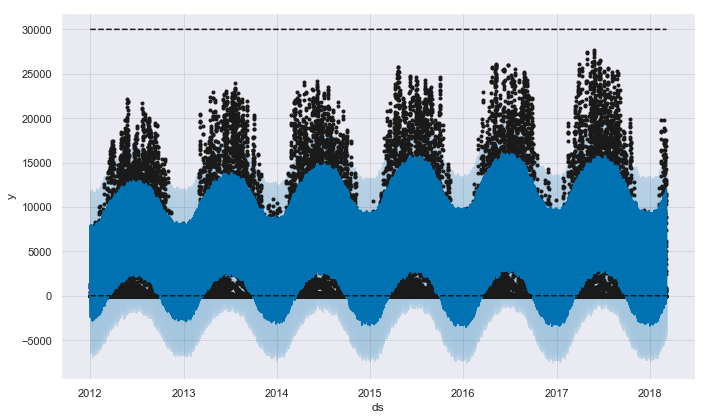

In [1408]:
fig = m.plot(fcst)

This model does not seem to fit the hourly data very well. We could make it work by setting all negative values to 0 but its not the best fit

let's see about the wind dataset

### Wind

In [1445]:
#preparing the dataframe for input to the model
wind_prophet_h = []
wind_prophet_h = wind_prophet['DE_wind_generation_actual'].copy()
wind_prophet_h = pd.DataFrame(wind_prophet_h)
wind_prophet_h['ds'] = wind_prophet_h.index
wind_prophet_h.columns = ['y', 'ds']
wind_prophet_h['ds'] = wind_prophet_h['ds'].dt.tz_convert(None)
wind_prophet_h = wind_prophet_h.reset_index(drop=True)
#wind_prophet_h['y']=wind_prophet_h.y.mask(wind_prophet_d.y == 0, 0.0001)

In [1446]:
wind_prophet_h['floor'] = 0
wind_prophet_h['cap'] = 50000

In [1447]:
m = Prophet(changepoint_prior_scale=0.01, growth='logistic', yearly_seasonality=10, seasonality_mode='multiplicative', interval_width=0.95)
m.add_seasonality(name='hourly', period=24, fourier_order=5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(wind_prophet_h)


In [1448]:
future = m.make_future_dataframe(periods=24, freq='H')
future['floor'] = 0
future['cap'] = 50000

In [1449]:
fcst_wind = m.predict(future)

In [1450]:
fcst_wind.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,hourly,hourly_lower,hourly_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-12-31 23:00:00,4092.103596,50000,0,-3801.007473,17573.635549,4092.103596,4092.103596,0.021443,0.021443,0.021443,0.018440,0.018440,0.018440,-0.034046,-0.034046,-0.034046,0.718794,0.718794,0.718794,-0.010162,-0.010162,-0.010162,0.723120,0.723120,0.723120,0.0,0.0,0.0,7033.485103
1,2010-01-01 00:00:00,4092.131710,50000,0,-4518.858030,18785.600362,4092.131710,4092.131710,0.006656,0.006656,0.006656,0.016542,0.016542,0.016542,-0.036859,-0.036859,-0.036859,0.694761,0.694761,0.694761,-0.014055,-0.014055,-0.014055,0.722477,0.722477,0.722477,0.0,0.0,0.0,6935.183719
2,2010-01-01 01:00:00,4092.159823,50000,0,-4719.889396,17740.971933,4092.159823,4092.159823,-0.003093,-0.003093,-0.003093,0.014691,0.014691,0.014691,-0.039622,-0.039622,-0.039622,0.675843,0.675843,0.675843,-0.017961,-0.017961,-0.017961,0.721828,0.721828,0.721828,0.0,0.0,0.0,6857.816094
3,2010-01-01 02:00:00,4092.187937,50000,0,-3899.451417,17286.506514,4092.187937,4092.187937,-0.006979,-0.006979,-0.006979,0.012891,0.012891,0.012891,-0.042327,-0.042327,-0.042327,0.662902,0.662902,0.662902,-0.021855,-0.021855,-0.021855,0.721172,0.721172,0.721172,0.0,0.0,0.0,6804.907816
4,2010-01-01 03:00:00,4092.216050,50000,0,-4424.670433,17901.573763,4092.216050,4092.216050,-0.009958,-0.009958,-0.009958,0.011147,0.011147,0.011147,-0.044971,-0.044971,-0.044971,0.651019,0.651019,0.651019,-0.025710,-0.025710,-0.025710,0.720510,0.720510,0.720510,0.0,0.0,0.0,6756.327228


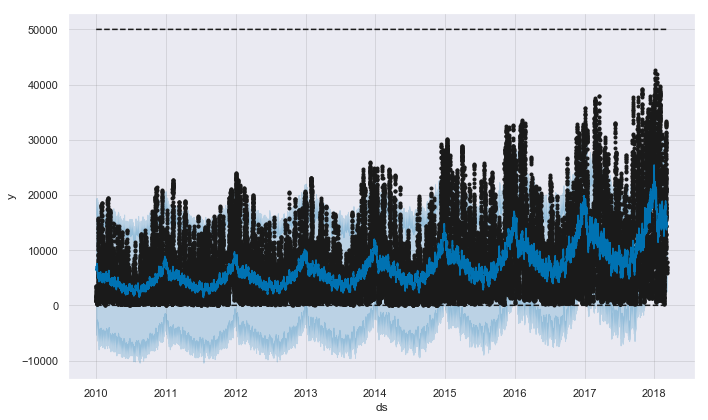

In [1451]:
fig = m.plot(fcst_wind)

Again, this model does not seem to work well with our data having the hard floor of 0. Let's look at daily aggregated data

## Daily
can adjust yearly_seasonality=20 in prophet models too
### Wind

In [1452]:
daily_w =  wind_prophet['DE_wind_generation_actual'].resample('D').sum()

/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


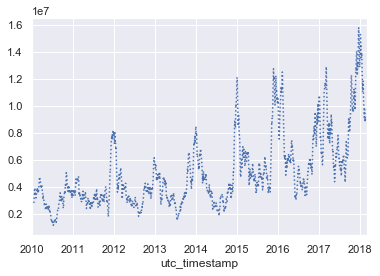

In [1453]:
#daily['DE_wind_generation_actual'].rolling(30, center=True).sum().plot(style=[':', '--', '-'])
daily_w.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

In [1454]:
wind_prophet_d = []
wind_prophet_d = daily_w.copy()

In [1455]:
wind_prophet_d.head()

utc_timestamp
2009-12-31 00:00:00+00:00     3515.0
2010-01-01 00:00:00+00:00    48709.0
2010-01-02 00:00:00+00:00    24628.0
2010-01-03 00:00:00+00:00    22963.0
2010-01-04 00:00:00+00:00    59318.0
Freq: D, Name: DE_wind_generation_actual, dtype: float64

In [1456]:
#lets make this into a dataframe so we can work with it easier
wind_prophet_d = pd.DataFrame(wind_prophet_d)

In [1457]:
wind_prophet_d.head()

,DE_wind_generation_actual
utc_timestamp,
2009-12-31 00:00:00+00:00,3515.0
2010-01-01 00:00:00+00:00,48709.0
2010-01-02 00:00:00+00:00,24628.0
2010-01-03 00:00:00+00:00,22963.0
2010-01-04 00:00:00+00:00,59318.0


In [1458]:
wind_prophet_d['ds'] = wind_prophet_d.index

In [1459]:
wind_prophet_d.columns = ['y', 'ds']
wind_prophet_d['ds'] = wind_prophet_d['ds'].dt.tz_convert(None)

In [1460]:
wind_prophet_d = wind_prophet_d.reset_index(drop=True)

In [1462]:
wind_prophet_d['floor'] = 0
wind_prophet_d['cap'] = 1000000

Below we have set up a for loop to perform cross validation over the changepoint_prior_scale which is pretty much the only hyperparameter. We will select the best one based on the rmse from the cross validation. The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date.

Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

The cross validation RMSE scores being produced are effectively test results

INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-04-06 00:00:00 and 2017-03-05 00:00:00


0.001
                        horizon           mse           rmse            mae  \
count                      4272  4.272000e+03    4272.000000    4272.000000   
mean   201 days 04:36:24.269662  2.058229e+10  142970.577752  111096.109318   
std     94 days 20:59:06.387092  3.332857e+09   11905.357716    8945.333637   
min            37 days 00:00:00  1.249282e+10  111771.277171   90430.452825   
25%           119 days 00:00:00  1.867352e+10  136651.089656  105024.488575   
50%           201 days 00:00:00  2.062924e+10  143628.833182  111451.452035   
75%           283 days 00:00:00  2.291244e+10  151368.562643  116656.286778   
max           365 days 00:00:00  2.707927e+10  164557.807951  129085.347088   

              mape     coverage  
count  4272.000000  4272.000000  
mean      1.428528     0.656303  
std       0.149297     0.045281  
min       1.136088     0.554852  
25%       1.331173     0.628692  
50%       1.435192     0.664557  
75%       1.534352     0.691983  
max       

INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-04-06 00:00:00 and 2017-03-05 00:00:00


0.005
                        horizon           mse           rmse            mae  \
count                      4272  4.272000e+03    4272.000000    4272.000000   
mean   201 days 04:36:24.269662  1.906473e+10  137479.131045  103494.939532   
std     94 days 20:59:06.387092  3.527179e+09   12816.140375    8379.728559   
min            37 days 00:00:00  1.178389e+10  108553.612927   86138.262060   
25%           119 days 00:00:00  1.665178e+10  129041.794495   97003.894422   
50%           201 days 00:00:00  1.837069e+10  135538.500404  101912.614815   
75%           283 days 00:00:00  2.224432e+10  149145.306724  109872.174021   
max           365 days 00:00:00  2.589104e+10  160906.927248  121175.593776   

              mape     coverage  
count  4272.000000  4272.000000  
mean      1.191224     0.681394  
std       0.124018     0.034192  
min       0.956237     0.607595  
25%       1.075997     0.664557  
50%       1.177937     0.681435  
75%       1.287907     0.704641  
max       

INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-04-06 00:00:00 and 2017-03-05 00:00:00


0.01
                        horizon           mse           rmse            mae  \
count                      4272  4.272000e+03    4272.000000    4272.000000   
mean   201 days 04:36:24.269662  1.874763e+10  136404.253866  102866.383916   
std     94 days 20:59:06.387092  3.228031e+09   11897.150850    8022.579314   
min            37 days 00:00:00  1.180080e+10  108631.508944   85928.059465   
25%           119 days 00:00:00  1.655326e+10  128659.462337   97371.585091   
50%           201 days 00:00:00  1.825126e+10  135097.239730  101650.702888   
75%           283 days 00:00:00  2.174854e+10  147473.862520  109442.491147   
max           365 days 00:00:00  2.480442e+10  157494.192012  119320.912486   

              mape     coverage  
count  4272.000000  4272.000000  
mean      1.177145     0.679007  
std       0.124587     0.032808  
min       0.949798     0.611814  
25%       1.063692     0.658228  
50%       1.165341     0.677215  
75%       1.279073     0.698840  
max       1

INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-04-06 00:00:00 and 2017-03-05 00:00:00


0.05
                        horizon           mse           rmse            mae  \
count                      4272  4.272000e+03    4272.000000    4272.000000   
mean   201 days 04:36:24.269662  2.003594e+10  140859.440666  106250.997698   
std     94 days 20:59:06.387092  3.955156e+09   13950.037246    9637.094773   
min            37 days 00:00:00  1.291508e+10  113644.542196   88827.207950   
25%           119 days 00:00:00  1.679126e+10  129581.098937   98607.777095   
50%           201 days 00:00:00  1.936204e+10  139147.558275  104974.193047   
75%           283 days 00:00:00  2.349540e+10  153282.107710  114826.552612   
max           365 days 00:00:00  2.788554e+10  166989.627562  125862.533015   

              mape     coverage  
count  4272.000000  4272.000000  
mean      1.176829     0.651601  
std       0.122690     0.033628  
min       0.951058     0.584388  
25%       1.068221     0.628692  
50%       1.162853     0.656118  
75%       1.274271     0.679325  
max       1

INFO:fbprophet:Making 13 forecasts with cutoffs between 2011-04-06 00:00:00 and 2017-03-05 00:00:00


0.1
                        horizon           mse           rmse            mae  \
count                      4272  4.272000e+03    4272.000000    4272.000000   
mean   201 days 04:36:24.269662  2.064749e+10  142896.563684  107366.203532   
std     94 days 20:59:06.387092  4.332467e+09   15103.524427   10794.816138   
min            37 days 00:00:00  1.328463e+10  115258.951894   88850.985361   
25%           119 days 00:00:00  1.699639e+10  130370.185553   97765.714512   
50%           201 days 00:00:00  2.030880e+10  142508.933400  106097.626295   
75%           283 days 00:00:00  2.435063e+10  156046.868960  116320.790211   
max           365 days 00:00:00  2.916210e+10  170769.142917  128713.399522   

              mape     coverage  
count  4272.000000  4272.000000  
mean      1.132065     0.645657  
std       0.121850     0.045253  
min       0.885109     0.563291  
25%       1.039581     0.609705  
50%       1.112894     0.649789  
75%       1.226031     0.681435  
max       1.

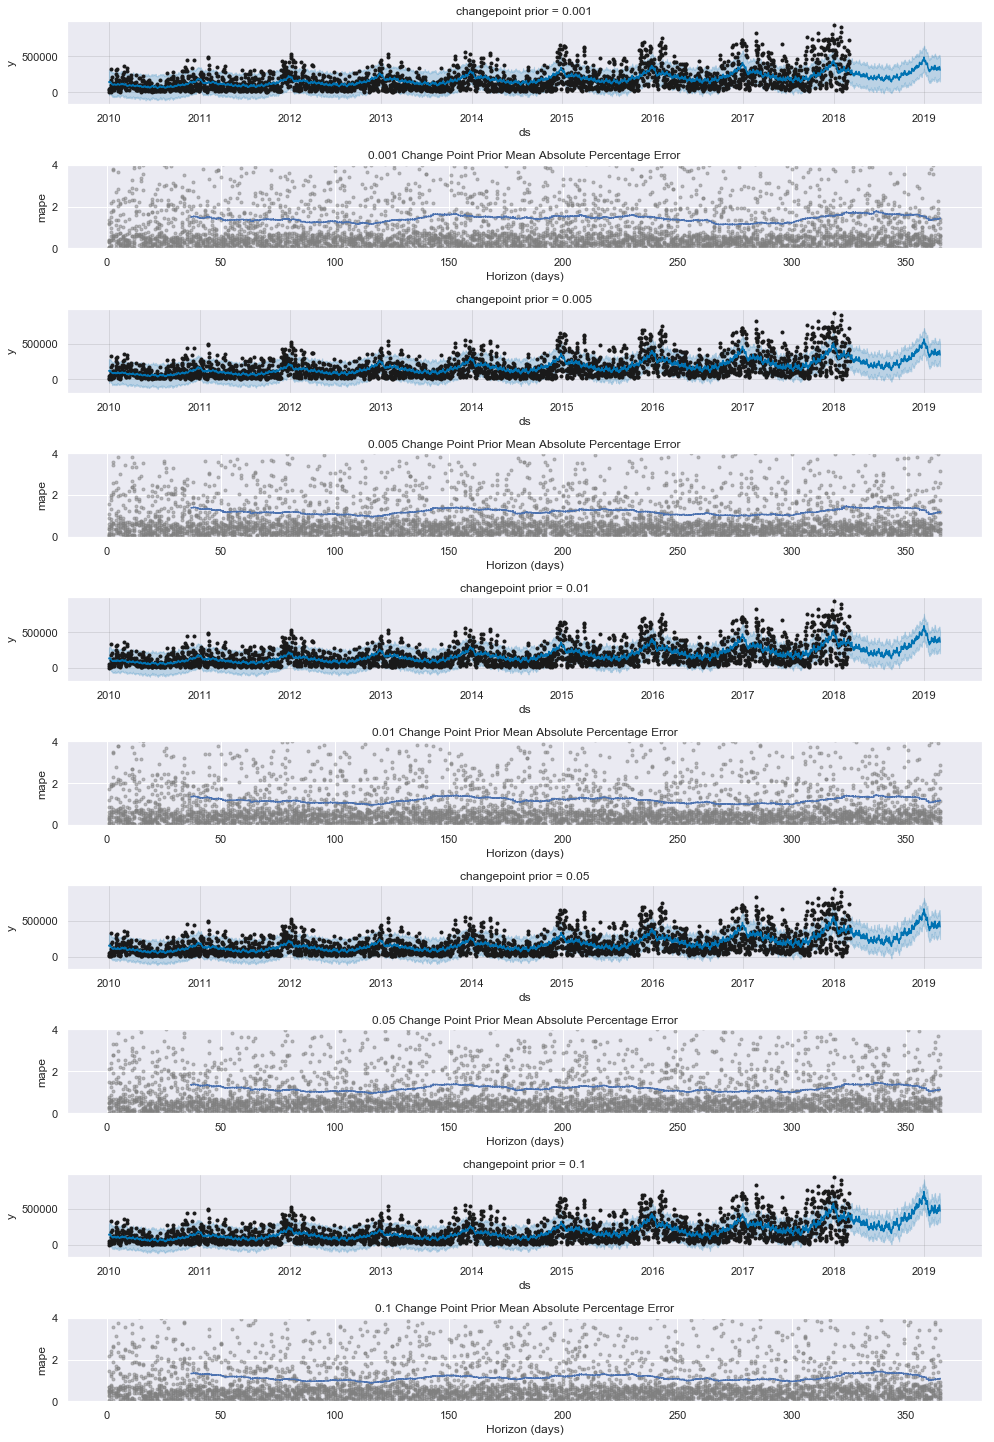

In [1463]:
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0


for i in [0.001, 0.005, 0.01, 0.05, 0.10]:
    m_w = Prophet(changepoint_prior_scale=i, daily_seasonality=True, seasonality_mode='multiplicative')
    m_w.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    #fit the prophet model on the data
    m_w.fit(wind_prophet_d)
    # make a dataframe of the next two years 
    future = m_w.make_future_dataframe(periods=365)
    #predict on this future dataframe
    forecast = m_w.predict(future)
    # plot the forecast 
    fig = m_w.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m_w, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,4)
    j += 1
    print(i)
    #print(pd.DataFrame(performance_metrics(df_cv)).head(2))
    print(pd.DataFrame(performance_metrics(df_cv).describe()))

From this we see that the best changepoint prior is 0.01 based off the rmse so that will be used going forward

In [1464]:
# I am going to select an interval width of 95% confidence to capture most of the data
m_wind = Prophet(changepoint_prior_scale=0.01, interval_width=0.95, daily_seasonality=True, seasonality_mode='multiplicative')
m_wind.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_wind.fit(wind_prophet_d)

In [1465]:
# I am going to put the cap and floor in again to try control the confidence interval
future = m_wind.make_future_dataframe(periods=30*2, freq='D')
future['floor'] = 0
future['cap'] = 1000000

In [1466]:
fcst_wind = m_wind.predict(future)

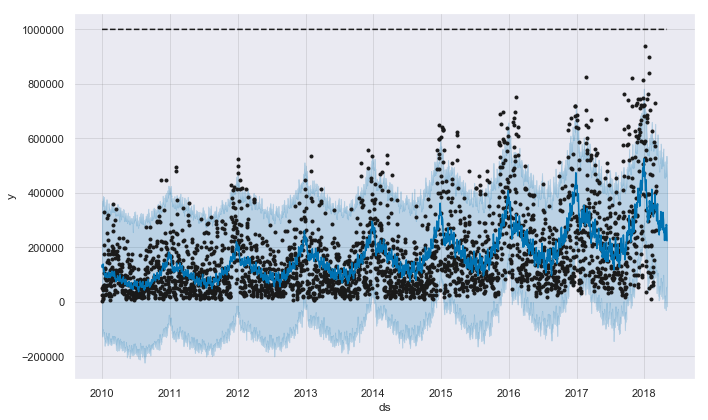

In [1467]:
fig = m_wind.plot(fcst_wind)

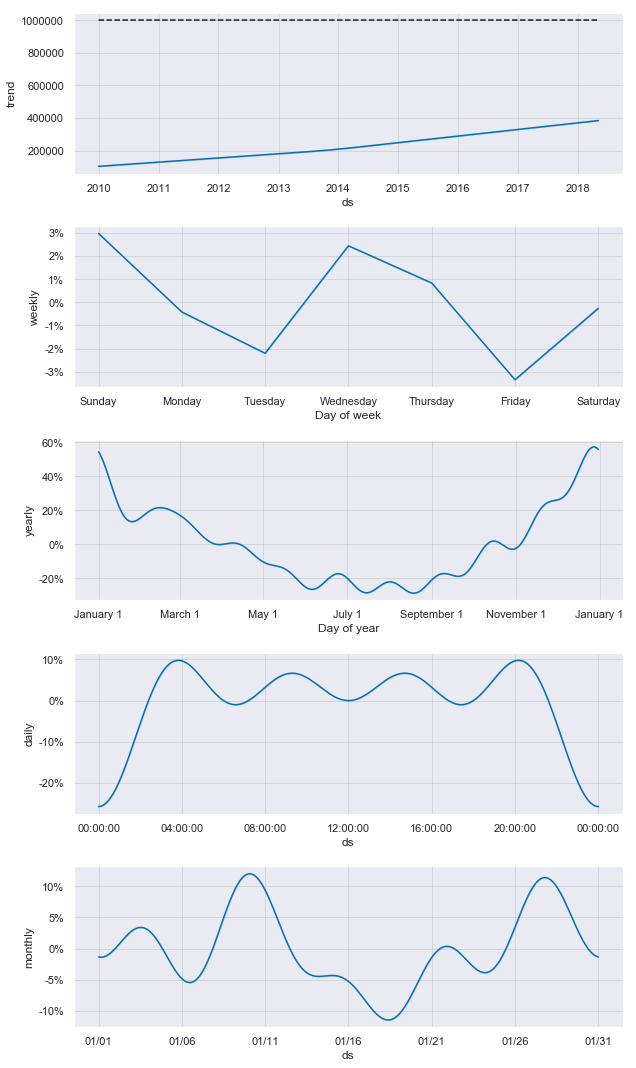

In [1468]:
fig = m_wind.plot_components(fcst_wind)

### Solar
Let's first set up the dataset and then perform cross validation on the data. After that a model will be run with the optimal change_point value

In [1469]:
daily_s =  solar_prophet['DE_solar_generation_actual'].resample('D').sum()

/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


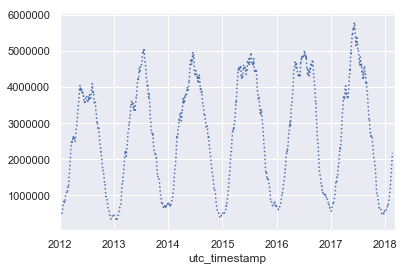

In [1470]:
daily_s.rolling(30, center=True).sum().plot(style=[':', '--', '-'])

In [1471]:
solar_prophet_d = []
solar_prophet_d = daily_s.copy()
solar_prophet_d = pd.DataFrame(solar_prophet_d)
solar_prophet_d['ds'] = solar_prophet_d.index
solar_prophet_d.columns = ['y', 'ds']
solar_prophet_d['ds'] = solar_prophet_d['ds'].dt.tz_convert(None)
solar_prophet_d = solar_prophet_d.reset_index(drop=True)

Preparing a cap and floor to control the confidence intervals

In [1472]:
solar_prophet_d['floor'] = 0
solar_prophet_d['cap'] = 300000

Below we will perform our cross validation again but for solar generation. With the size of our data and the size of the cross validation periods, 9 cross validations will be performed

INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-03-05 00:00:00


0.001
                      horizon           mse          rmse           mae  mape  \
count                      45  4.500000e+01     45.000000     45.000000  45.0   
mean         39 days 08:00:00  1.391475e+09  37302.175781  30683.535741   inf   
std    1 days 12:10:52.900857  1.142367e+07    152.923438    170.378189   NaN   
min          37 days 00:00:00  1.370652e+09  37022.313395  30362.794819   inf   
25%          38 days 00:00:00  1.384753e+09  37212.263179  30586.062540   NaN   
50%          39 days 00:00:00  1.391598e+09  37304.123935  30682.480921   NaN   
75%          41 days 00:00:00  1.396023e+09  37363.393870  30778.418527   NaN   
max          42 days 00:00:00  1.425470e+09  37755.394393  31158.018033   inf   

        coverage  
count  45.000000  
mean    0.733875  
std     0.005266  
min     0.725610  
25%     0.731707  
50%     0.731707  
75%     0.734756  
max     0.743902  


INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-03-05 00:00:00


0.005
                      horizon           mse          rmse           mae  mape  \
count                      45  4.500000e+01     45.000000     45.000000  45.0   
mean         39 days 08:00:00  1.278485e+09  35755.736973  29762.724096   inf   
std    1 days 12:10:52.900857  7.965216e+06    111.408441    134.140288   NaN   
min          37 days 00:00:00  1.264064e+09  35553.677371  29498.716124   inf   
25%          38 days 00:00:00  1.271020e+09  35651.365912  29691.321448   NaN   
50%          39 days 00:00:00  1.278096e+09  35750.473794  29781.049622   NaN   
75%          41 days 00:00:00  1.284908e+09  35845.618104  29853.477010   NaN   
max          42 days 00:00:00  1.294741e+09  35982.502910  30005.320724   inf   

        coverage  
count  45.000000  
mean    0.596816  
std     0.006407  
min     0.588415  
25%     0.591463  
50%     0.594512  
75%     0.600610  
max     0.609756  


INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-03-05 00:00:00


0.01
                      horizon           mse          rmse           mae  mape  \
count                      45  4.500000e+01     45.000000     45.000000  45.0   
mean         39 days 08:00:00  1.272966e+09  35678.517962  29574.427366   inf   
std    1 days 12:10:52.900857  6.889027e+06     96.500665    109.087699   NaN   
min          37 days 00:00:00  1.258768e+09  35479.124547  29380.128927   inf   
25%          38 days 00:00:00  1.269264e+09  35626.731860  29493.341777   NaN   
50%          39 days 00:00:00  1.271324e+09  35655.632293  29555.309870   NaN   
75%          41 days 00:00:00  1.276873e+09  35733.359797  29635.238562   NaN   
max          42 days 00:00:00  1.287524e+09  35882.089081  29821.837737   inf   

        coverage  
count  45.000000  
mean    0.621003  
std     0.004352  
min     0.612805  
25%     0.618902  
50%     0.621951  
75%     0.621951  
max     0.628049  


INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-03-05 00:00:00


0.05
                      horizon           mse          rmse           mae  mape  \
count                      45  4.500000e+01     45.000000     45.000000  45.0   
mean         39 days 08:00:00  1.339930e+09  36604.802797  29944.743304   inf   
std    1 days 12:10:52.900857  1.004092e+07    137.188501    119.403730   NaN   
min          37 days 00:00:00  1.320199e+09  36334.537239  29692.826139   inf   
25%          38 days 00:00:00  1.333915e+09  36522.798869  29861.060692   NaN   
50%          39 days 00:00:00  1.339867e+09  36604.200375  29943.605896   NaN   
75%          41 days 00:00:00  1.348028e+09  36715.498180  29999.992650   NaN   
max          42 days 00:00:00  1.356433e+09  36829.780357  30173.033568   inf   

        coverage  
count  45.000000  
mean    0.598916  
std     0.003087  
min     0.591463  
25%     0.597561  
50%     0.600610  
75%     0.600610  
max     0.603659  


INFO:fbprophet:Making 9 forecasts with cutoffs between 2013-03-26 00:00:00 and 2017-03-05 00:00:00


0.1
                      horizon           mse          rmse           mae  mape  \
count                      45  4.500000e+01     45.000000     45.000000  45.0   
mean         39 days 08:00:00  1.414651e+09  37611.418022  30442.647693   inf   
std    1 days 12:10:52.900857  1.370815e+07    182.317980    134.295414   NaN   
min          37 days 00:00:00  1.388759e+09  37266.056557  30181.509401   inf   
25%          38 days 00:00:00  1.404034e+09  37470.448166  30319.669156   NaN   
50%          39 days 00:00:00  1.415033e+09  37616.921832  30465.723806   NaN   
75%          41 days 00:00:00  1.427931e+09  37787.968987  30560.155771   NaN   
max          42 days 00:00:00  1.434870e+09  37879.677937  30660.652287   inf   

        coverage  
count  45.000000  
mean    0.588618  
std     0.003007  
min     0.582317  
25%     0.585366  
50%     0.588415  
75%     0.591463  
max     0.594512  


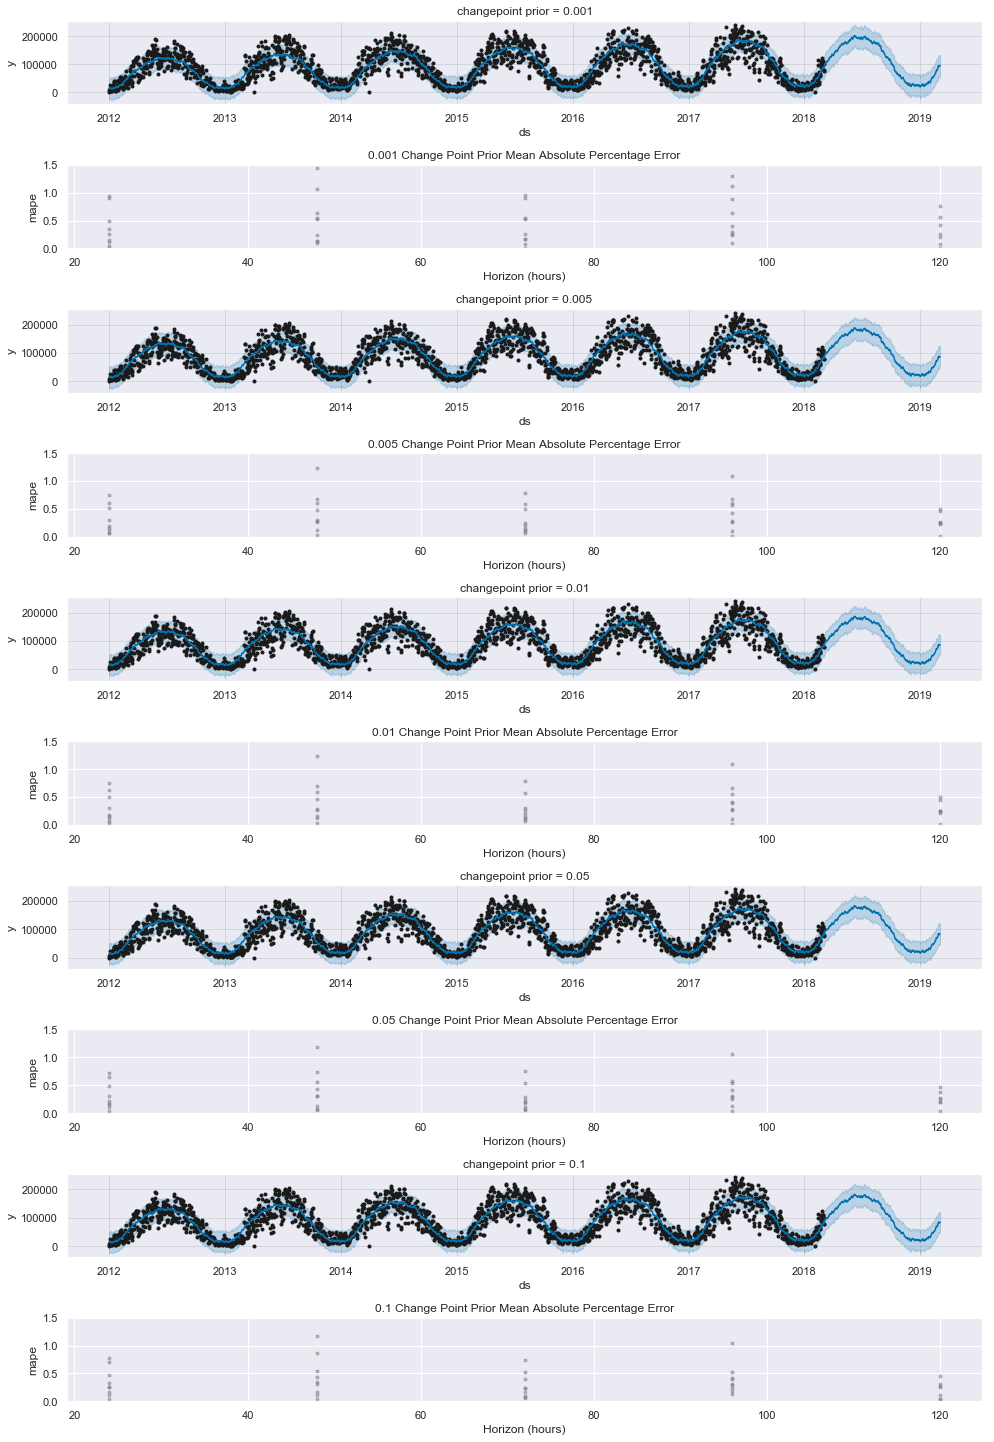

In [1473]:
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0


for i in [0.001, 0.005, 0.01, 0.05, 0.10]:
    m_s = Prophet(changepoint_prior_scale=i, daily_seasonality=True, seasonality_mode='multiplicative')
    m_s.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    #fit the prophet model on the data
    m_s.fit(solar_prophet_d)
    # make a dataframe of the next two years 
    future = m_s.make_future_dataframe(periods=365)
    #predict on this future dataframe
    forecast = m_s.predict(future)
    # plot the forecast 
    fig = m_s.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m_s, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,1.5)
    j += 1
    print(i)
    #print(pd.DataFrame(performance_metrics(df_cv)).head(2))
    print(pd.DataFrame(performance_metrics(df_cv).describe()))

From these results, a change point of 0.01 appears to be the best value

In [1474]:
m_solar = Prophet(changepoint_prior_scale=0.01, interval_width=0.95, daily_seasonality=True)
m_solar.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_solar.fit(solar_prophet_d)

In [1475]:
future = m_solar.make_future_dataframe(periods=30*2, freq='D')
future['floor'] = 0
future['cap'] = 300000

In [1476]:
fcst_solar = m_solar.predict(future)

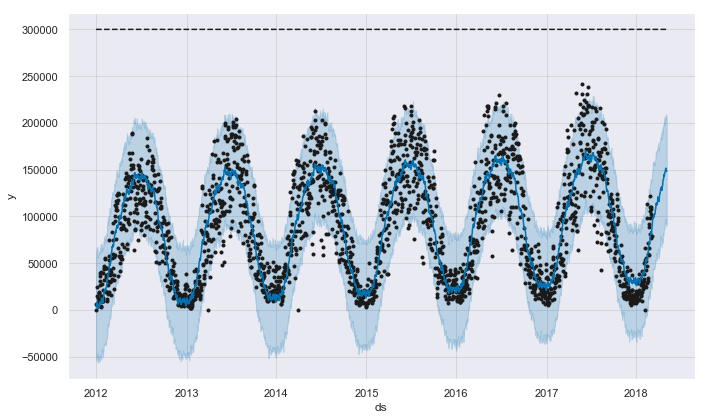

In [1477]:
fig = m_solar.plot(fcst_solar)

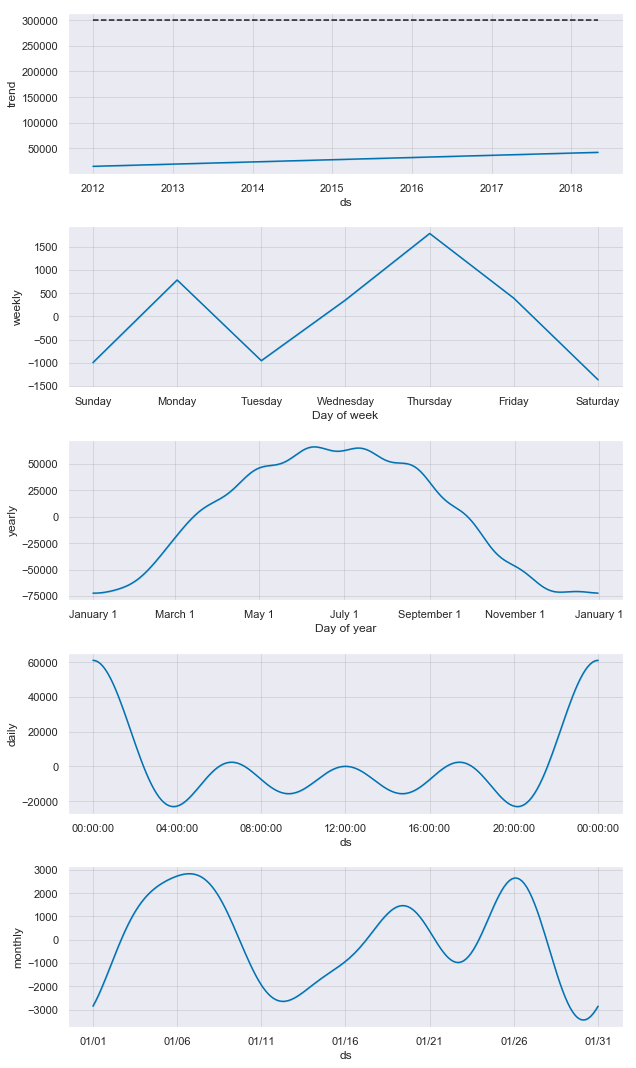

In [1478]:
fig = m_solar.plot_components(fcst_solar)

### Combining Daily Solar and Wind Forecasts for Analysis

In [1479]:
solar_names = ['solar_%s' % column for column in fcst_solar.columns]
wind_names = ['wind_%s' % column for column in fcst_wind.columns]
merge_solar_forecast = fcst_solar.copy()
merge_wind_forecast = fcst_wind.copy()
merge_solar_forecast.columns = solar_names
merge_wind_forecast.columns = wind_names
forecast = pd.merge(merge_solar_forecast, merge_wind_forecast, how = 'inner', left_on = 'solar_ds', right_on = 'wind_ds')
forecast = forecast.rename(columns={'solar_ds': 'Date'}).drop('wind_ds', axis=1)
forecast.head()

,Date,solar_trend,solar_cap,solar_yhat_lower,solar_yhat_upper,solar_trend_lower,solar_trend_upper,solar_additive_terms,solar_additive_terms_lower,solar_additive_terms_upper,solar_daily,solar_daily_lower,solar_daily_upper,solar_monthly,solar_monthly_lower,solar_monthly_upper,solar_weekly,solar_weekly_lower,solar_weekly_upper,solar_yearly,solar_yearly_lower,solar_yearly_upper,solar_multiplicative_terms,solar_multiplicative_terms_lower,solar_multiplicative_terms_upper,solar_yhat,wind_trend,wind_cap,wind_yhat_lower,wind_yhat_upper,wind_trend_lower,wind_trend_upper,wind_daily,wind_daily_lower,wind_daily_upper,wind_monthly,wind_monthly_lower,wind_monthly_upper,wind_multiplicative_terms,wind_multiplicative_terms_lower,wind_multiplicative_terms_upper,wind_weekly,wind_weekly_lower,wind_weekly_upper,wind_yearly,wind_yearly_lower,wind_yearly_upper,wind_additive_terms,wind_additive_terms_lower,wind_additive_terms_upper,wind_yhat
0,2011-12-31,15252.156968,300000,-54208.058551,58773.499532,15252.156968,15252.156968,-12113.019504,-12113.019504,-12113.019504,61011.460953,61011.460953,61011.460953,468.418600,468.418600,468.418600,-1365.868618,-1365.868618,-1365.868618,-72227.030439,-72227.030439,-72227.030439,0.0,0.0,0.0,3139.137464,154437.767443,1000000,-36193.142859,465492.031531,154437.767443,154437.767443,-0.257321,-0.257321,-0.257321,0.027816,0.027816,0.027816,0.329867,0.329867,0.329867,-0.002640,-0.002640,-0.002640,0.562012,0.562012,0.562012,0.0,0.0,0.0,205381.662536
1,2012-01-01,15263.912965,300000,-50179.629828,62924.551251,15263.912965,15263.912965,-10588.808966,-10588.808966,-10588.808966,61011.460953,61011.460953,61011.460953,1670.618318,1670.618318,1670.618318,-995.173729,-995.173729,-995.173729,-72275.714508,-72275.714508,-72275.714508,0.0,0.0,0.0,4675.103998,154507.469300,1000000,-15468.701539,448813.136950,154507.469300,154507.469300,-0.257321,-0.257321,-0.257321,0.030223,0.030223,0.030223,0.355349,0.355349,0.355349,0.029713,0.029713,0.029713,0.552734,0.552734,0.552734,0.0,0.0,0.0,209411.543043
2,2012-01-02,15275.668961,300000,-49689.717663,63834.593831,15275.668961,15275.668961,-8164.024778,-8164.024778,-8164.024778,61011.460953,61011.460953,61011.460953,2339.367117,2339.367117,2339.367117,784.460516,784.460516,784.460516,-72299.313364,-72299.313364,-72299.313364,0.0,0.0,0.0,7111.644183,154577.171157,1000000,-50282.830615,429853.950037,154577.171157,154577.171157,-0.257321,-0.257321,-0.257321,-0.004648,-0.004648,-0.004648,0.274538,0.274538,0.274538,-0.004223,-0.004223,-0.004223,0.540729,0.540729,0.540729,0.0,0.0,0.0,197014.431115
3,2012-01-03,15287.424958,300000,-53453.286308,66261.889865,15287.424958,15287.424958,-9530.710200,-9530.710200,-9530.710200,61011.460953,61011.460953,61011.460953,2709.040428,2709.040428,2709.040428,-954.838333,-954.838333,-954.838333,-72296.373249,-72296.373249,-72296.373249,0.0,0.0,0.0,5756.714758,154646.873014,1000000,-56473.788309,439905.041045,154646.873014,154646.873014,-0.257321,-0.257321,-0.257321,-0.046000,-0.046000,-0.046000,0.200784,0.200784,0.200784,-0.022054,-0.022054,-0.022054,0.526160,0.526160,0.526160,0.0,0.0,0.0,185697.470559
4,2012-01-04,15299.180955,300000,-50106.721506,62981.032551,15299.180955,15299.180955,-8079.198067,-8079.198067,-8079.198067,61011.460953,61011.460953,61011.460953,2821.267460,2821.267460,2821.267460,354.056588,354.056588,354.056588,-72265.983069,-72265.983069,-72265.983069,0.0,0.0,0.0,7219.982887,154716.574871,1000000,-55692.550605,430168.295362,154716.574871,154716.574871,-0.257321,-0.257321,-0.257321,-0.048911,-0.048911,-0.048911,0.227383,0.227383,0.227383,0.024383,0.024383,0.024383,0.509233,0.509233,0.509233,0.0,0.0,0.0,189896.540031


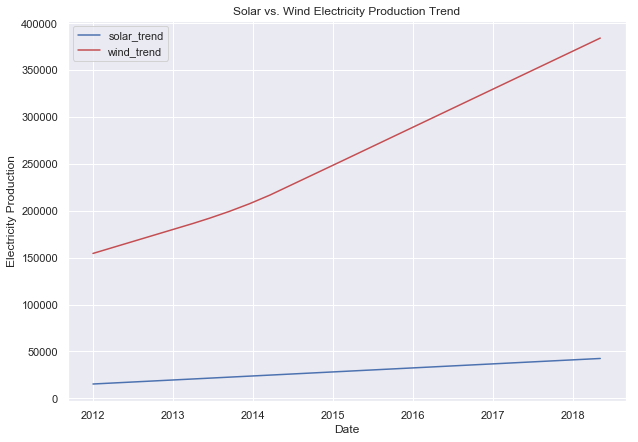

In [1480]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['solar_trend'], 'b-')
plt.plot(forecast['Date'], forecast['wind_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Electricity Production')
plt.title('Solar vs. Wind Electricity Production Trend');

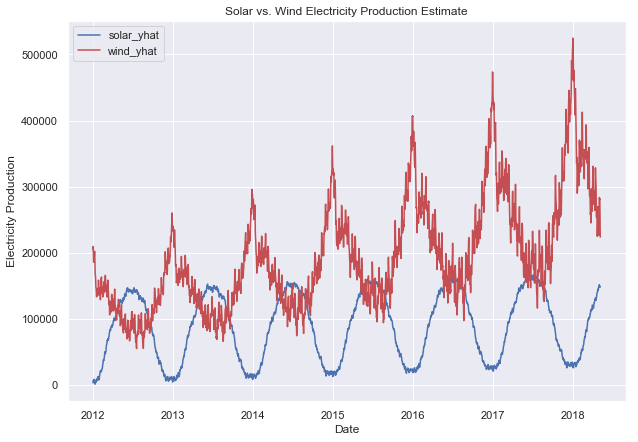

In [1481]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['solar_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['wind_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Electricity Production')
plt.title('Solar vs. Wind Electricity Production Estimate');

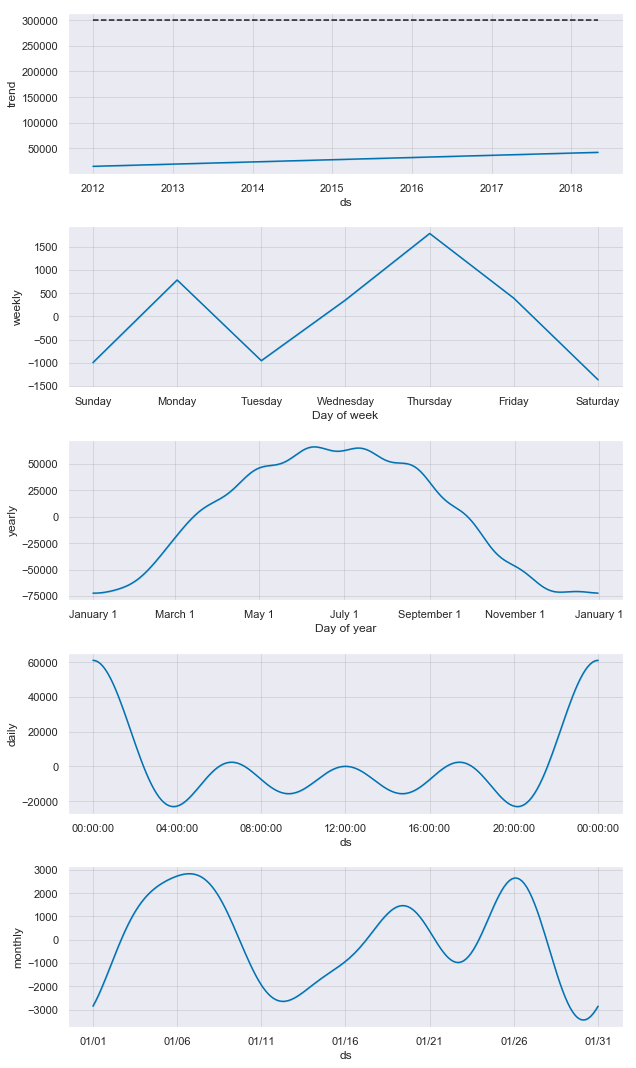

In [1482]:
m_solar.plot_components(fcst_solar);

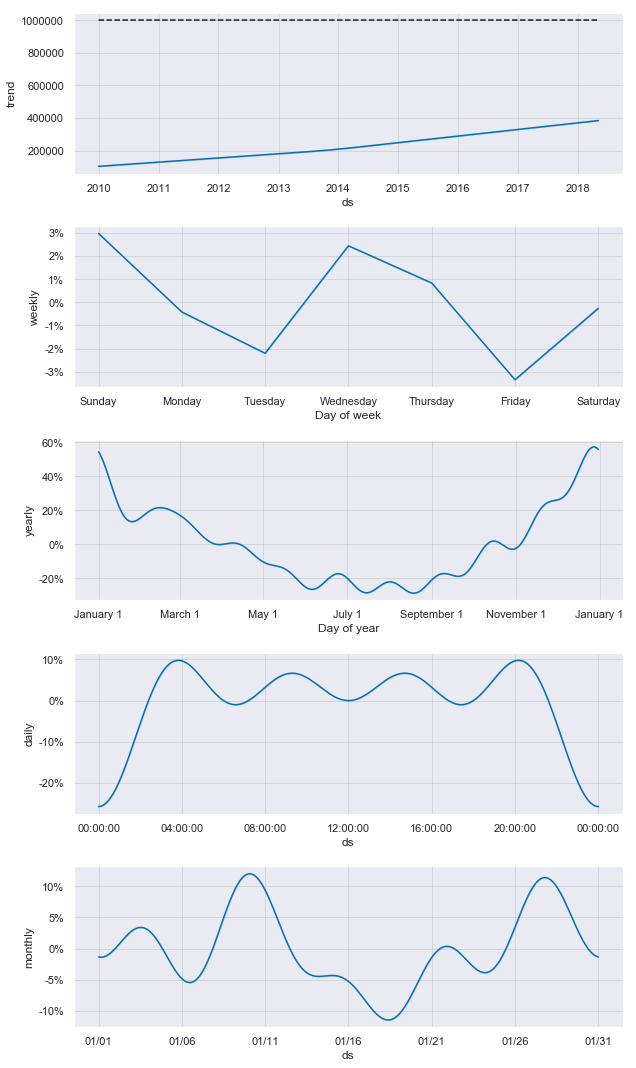

In [1483]:
m_wind.plot_components(fcst_wind);